# Comparison between deepchaos (official library) with edge-of-chaos (personal lib.)

In [31]:
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [15, 10]

In [2]:
from scipy.stats import hypsecant
def sech(x):
    return hypsecant.pdf(x) * np.pi

phi = np.tanh
dphi = lambda x: sech(x)**2
d2phi = lambda x: 2 * (np.tanh(x)**3 - np.tanh(x))

In [3]:
from cornet.constants import *
print("Weight sigmas (n=%d):" % nw, weight_sigmas)
print("Bias sigmas (n=%d):" % nb, bias_sigmas)

Weight sigmas (n=41): [1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5
 4.6 4.7 4.8 4.9 5. ]
Bias sigmas (n=41): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4. ]


In [17]:
from cornet.theory import qmap, q_fixed_point, compute_chi1, covmap

In [23]:
# Range of squared lengths for q map plot (panel A)
nq = 100
qmax = 15
qrange = np.linspace(0, qmax, nq)

qstars = np.zeros((nw, nb))
chi1 = np.zeros((nw, nb))

nq = 51
c12s = np.linspace(0, 1.0, nq)
crange = c12s
cstars = np.zeros((nw, nb))

for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        # Compute fixed points
        _, qstar = q_fixed_point(weight_sigma, bias_sigma, phi, qinit=3.0, tol_frac=0.01)
        qstars[widx, bidx] = qstar
        
        chi1[widx, bidx] = compute_chi1(qstar, weight_sigma, bias_sigma, dphi)
        
        cin = (c12s * qstar)
        cout = covmap(qstar, qstar,  cin, weight_sigma, bias_sigma, phi)
        # Remove  fixed point at cin = q*
        cstar = cin[np.argmin(np.abs(cin[:-1] - cout[:-1]))]
        cstars[widx, bidx] = cstar
        
cstars_unnormalized = cstars.copy()
cstars /= qstars

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [05:59<00:00,  8.76s/it]


In [19]:
qstars

array([[1.00514753e-03, 7.77754967e-02, 1.69769600e-01, ...,
        1.52408475e+01, 1.60154889e+01, 1.68099270e+01],
       [1.12749892e-01, 1.59548424e-01, 2.49885167e-01, ...,
        1.54102882e+01, 1.61858247e+01, 1.69811214e+01],
       [2.49513043e-01, 2.82414220e-01, 3.62494622e-01, ...,
        1.55963465e+01, 1.63728336e+01, 1.71690435e+01],
       ...,
       [1.88994591e+01, 1.89106327e+01, 1.89441468e+01, ...,
        3.43814251e+01, 3.51862598e+01, 3.60107542e+01],
       [1.97894056e+01, 1.98005468e+01, 1.98339643e+01, ...,
        3.52605642e+01, 3.60655678e+01, 3.68902583e+01],
       [2.06993668e+01, 2.07104774e+01, 2.07438035e+01, ...,
        3.61596850e+01, 3.69648303e+01, 3.77896896e+01]])

In [20]:
chi1

array([[0.99799675, 0.87624377, 0.77907419, ..., 0.13483773, 0.13160293,
        0.12851417],
       [1.01018936, 0.95372722, 0.8681236 , ..., 0.16227259, 0.15841492,
        0.15473092],
       [1.03350146, 1.0028973 , 0.93878535, ..., 0.19198576, 0.18746752,
        0.18315063],
       ...,
       [2.79538619, 2.79457401, 2.79214219, ..., 2.08039095, 2.05667834,
        2.0332082 ],
       [2.84788812, 2.84709958, 2.8447383 , ..., 2.14102692, 2.1172112 ,
        2.09361892],
       [2.90042095, 2.89965473, 2.89736009, ..., 2.20166427, 2.17776372,
        2.15406769]])

In [21]:
cstars

array([[0.  , 0.98, 0.98, ..., 0.98, 0.98, 0.98],
       [0.  , 0.98, 0.98, ..., 0.98, 0.98, 0.98],
       [0.  , 0.96, 0.98, ..., 0.98, 0.98, 0.98],
       ...,
       [0.  , 0.  , 0.  , ..., 0.8 , 0.82, 0.84],
       [0.  , 0.  , 0.  , ..., 0.8 , 0.8 , 0.82],
       [0.  , 0.  , 0.  , ..., 0.78, 0.8 , 0.8 ]])

## Tests with $\phi_{\theta}$ activation functions

In [24]:
import torch
import invint

In [28]:
def load_acttorch_torch(theta):
    zmin = .0001
    zmax = 5
    znum = 200
    max_err = .02
    xmax = 10
    npts = 100
    restart = False

    path_store = './'

    fs_acttorch = invint.FileStorage('../functions/InvInt_acttorch_theta-{:.4f}_err-{:.2e}_zmin-{:.2e}_zmax-{:.2e}_' + \
                                         'znum-{}_xmax-{:.2f}_npts-{}_torch_.pkl', \
        {'theta': float, 'err': float, 'zmin': float, 'zmax': float, 'znum': int, 'xmax': float,  'npts': int})

    fname_all = fs_acttorch.find_all(path_store, \
        {'theta': theta, 'zmin': zmin, 'zmax': zmax, 'znum': znum, 'xmax': xmax, 'npts': npts})
    
    if len(fname_all) == 0:
        raise ValueError('No torch activation function file found for theta = {:.2f}'.format(theta))
        
    best_fname = min(fname_all, key = lambda k: fname_all[k]['err'])

    print('Loading...')
    dct_load = torch.load(best_fname)
    
    acttorch = invint.ActivationFunction(theta)
    acttorch.load_state_dict(dct_load['acttorch'])
    err = fs_acttorch.extract_dct(best_fname)['err']
    err_torch = dct_load['err_torch']
    print('Done.')
    
    return {'acttorch': acttorch, 'err': err, 'err_torch': err_torch}

In [29]:
lst_theta = [2.06, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]
acttorch_torch = {}
for theta in lst_theta:
    dct = load_acttorch_torch(theta)
    acttorch_torch[theta] = dct['acttorch']

Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.
Loading...
Done.


Text(0.5, 1.0, 'Activation function')

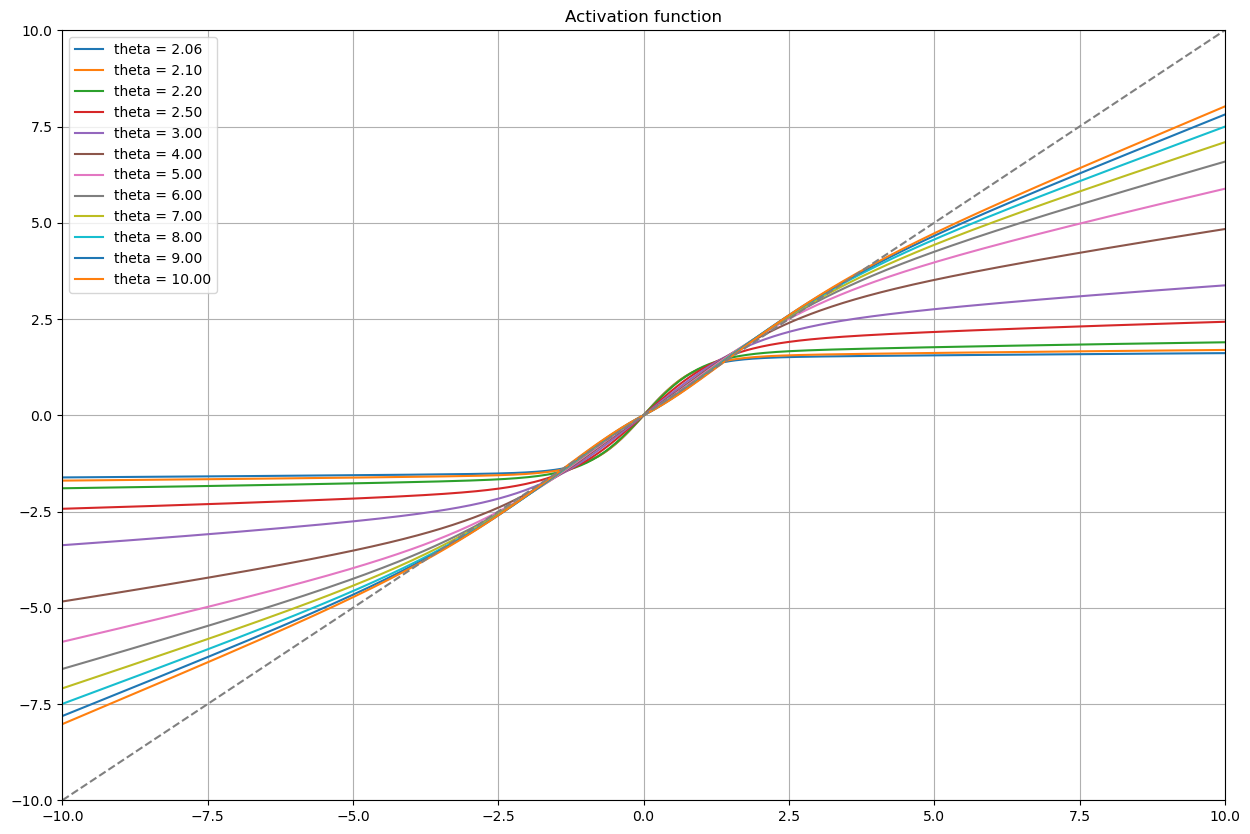

In [32]:
lst_x = np.linspace(-10, 10, 400)

for theta, acttorch in acttorch_torch.items():
    plt.plot(lst_x, acttorch.forward_ng(lst_x), label = 'theta = {:.2f}'.format(theta))

plt.plot([-10, 10], [-10, 10], color = 'grey', linestyle = 'dashed')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid(True)
plt.legend()
plt.title('Activation function')

In [33]:
dct_phi = {theta: acttorch.forward_ng for theta, acttorch in acttorch_torch.items()}
dct_phi_p = {theta: acttorch.derivative_ng for theta, acttorch in acttorch_torch.items()}
dct_phi_pp = {theta: acttorch.derivative2_ng for theta, acttorch in acttorch_torch.items()}

In [ ]:
theta = 10

phi = lambda x: dct_phi[theta](torch.tensor(x)).numpy()
dphi = lambda x: dct_phi_p[theta](torch.tensor(x)).numpy()

# Range of squared lengths for q map plot (panel A)
nq = 100
qmax = 15
qrange = np.linspace(0, qmax, nq)

qstars = np.zeros((nw, nb))
chi1 = np.zeros((nw, nb))

nq = 51
c12s = np.linspace(0, 1.0, nq)
crange = c12s
cstars = np.zeros((nw, nb))

for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        # Compute fixed points
        _, qstar = q_fixed_point(weight_sigma, bias_sigma, phi, qinit=3.0, tol_frac=0.01)
        qstars[widx, bidx] = qstar
        
        chi1[widx, bidx] = compute_chi1(qstar, weight_sigma, bias_sigma, dphi)
        
        cin = (c12s * qstar)
        cout = covmap(qstar, qstar,  cin, weight_sigma, bias_sigma, phi)
        # Remove  fixed point at cin = q*
        cstar = cin[np.argmin(np.abs(cin[:-1] - cout[:-1]))]
        cstars[widx, bidx] = cstar
        
cstars_unnormalized = cstars.copy()
cstars /= qstars

  0%|                                                                                                                                 | 0/41 [00:00<?, ?it/s]/home/pwolinsk/Documents/_Code/deepchaos/tests/cornet/theory.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frac_err = (np.array(qs) - q)**2 / (1e-9 + q**2)
 20%|███████████████████████▌                                                                                                 | 8/41 [02:00<09:05, 16.54s/it]

In [34]:
dphi = dct_phi_p[10]